### Vanilla Theano
Layers, MNIST, MLP

In [1]:
import numpy as np
import theano
import theano.tensor as T
from helpers import load_dataset
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: Tesla K40c (CNMeM is disabled, cuDNN 4007)


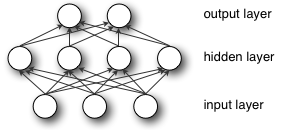

In [4]:
Image("./images/mlp.png")

#### let's create these layers!!!

In [2]:
class Hidden_Layer(object):
    def __init__(self,input_, n_in, n_out):
        
        self.W = theano.shared(
                    value=np.random.rand(n_in,n_out).astype(theano.config.floatX), 
                    name='W', 
                    borrow=True)
        #borrow variable for optimizing memory!!

        self.b = theano.shared(
                    value=np.zeros((n_out,), dtype=theano.config.floatX), 
                    name='b', 
                    borrow=True)

        lin_output = T.dot(input_, self.W) + self.b
        
        self.output = T.nnet.relu(lin_output)
        self.params = [self.W, self.b]

In [32]:
class Output_Layer(object):
    
    def __init__(self, input_, n_in, n_out):
        
        self.W = theano.shared(  
            value=np.zeros((n_in, n_out),dtype=theano.config.floatX),
            name='W',
            borrow=True)
            
        self.b = theano.shared(
            value=np.zeros((n_out,),dtype=theano.config.floatX),
            name='b',
            borrow=True
        )
        
        #probabilities of classes given image x
        self.p_y_given_x = T.nnet.softmax(T.dot(input_, self.W) + self.b)
        
        #class having maximum probabilty is prediction
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)
        
        self.params = [self.W, self.b]
        
    def negative_log_likelihood(self, y):
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])
    
    def errors(self, y):
        return T.mean(T.neq(self.y_pred, y))        

#### Model parameters!!

In [20]:
n_in          = 28 * 28   # input image size
n_hidden      = 100      # number of hidden units
n_out         = 10       # ten way classification
learning_rate = 0.01     # for gradient descent
L1_reg        = 0.001    # l1 regularizer coefficient
L2_reg        = 0.0001   # l2 regularizer coefficient
n_epochs      = 10       # iterations
batch_size    = 100      # mini batch size

In [33]:
#get dataset
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset()

#flatten image
x_train = x_train.reshape((-1,n_in)).astype(np.float32)
x_val = x_val.reshape((-1,n_in)).astype(np.float32)
x_test = x_test.reshape((-1,n_in)).astype(np.float32)

#labels are integers
y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)
y_test = y_test.astype(np.int32)

In [34]:
#define symbolic tensors (or placeholders as tensorflow calls it)
x = T.matrix("input")
y = T.ivector("output")

In [35]:
#instantiate hidden class and get a hidden layer!!

hidden_layer1 = Hidden_Layer(input_ = x,
                            n_in = n_in,
                            n_out = n_hidden)

#instantiate output class and get a output layer!!

output_layer2 = Output_Layer(input_ = hidden_layer1.output,
                             n_in = n_hidden,
                             n_out = n_out)

In [36]:
#lets calculate regularizers!
L1 = abs(hidden_layer1.W).sum() + abs(output_layer2.W).sum()
L2 = (hidden_layer1.W ** 2).sum() + (output_layer2.W ** 2).sum()

#get all parametrs of the model
params = hidden_layer1.params + output_layer2.params

#define cost function
cost = output_layer2.negative_log_likelihood(y) + L1_reg*L1 + L2_reg*L2

#calulate gradient with respect to all of them!!
gparams = []
for param in params:
    gparams.append(T.grad(cost, param))
    
#create updation rules
updates = [] 
for param, gparam in zip(params, gparams):
    updates.append((param, param - learning_rate * gparam))

In [37]:
#compile theano functions for training, validation and testing!!

train_model = theano.function(inputs = [x,y],
                              outputs = cost,
                              updates = updates)

validate_model = theano.function(inputs = [x,y],
                                 outputs = output_layer2.errors(y) )

test_model = theano.function(inputs = [x,y],
                             outputs = [output_layer2.errors(y), output_layer2.y_pred ] )

In [38]:
for epoch in range(n_epochs):
    print "epoch:",epoch+1
    train_cost = []
    for i in range(0, x_train.shape[0]- batch_size, batch_size ):
        train_cost.append( train_model(x_train[i:i+batch_size], y_train[i:i+batch_size]) )
    print "Training Cost:", np.mean(train_cost)
    
    valid_err = []
    for i in range(0, x_val.shape[0]- batch_size, batch_size ):
        valid_err.append( validate_model(x_val[i:i+batch_size], y_val[i:i+batch_size]) )
    print "Testing Error:", np.mean(valid_err)     

epoch: 1
Training Cost: 511.517
Testing Error: 0.475555555556
epoch: 2
Training Cost: 59.1313
Testing Error: 0.290303030303
epoch: 3
Training Cost: 45.5234
Testing Error: 0.22202020202
epoch: 4
Training Cost: 41.9724
Testing Error: 0.245252525253
epoch: 5
Training Cost: 40.2374
Testing Error: 0.268282828283
epoch: 6
Training Cost: 39.299
Testing Error: 0.201616161616
epoch: 7
Training Cost: 38.2055
Testing Error: 0.181212121212
epoch: 8
Training Cost: 37.2145
Testing Error: 0.183838383838
epoch: 9
Training Cost: 36.3226
Testing Error: 0.181515151515
epoch: 10
Training Cost: 35.5162
Testing Error: 0.173737373737


In [16]:
err , y_hat = test_model(x_test[0:1],y_test[0:1])

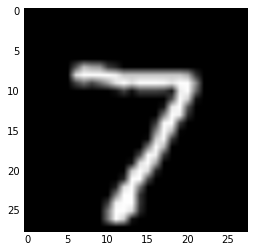

In [17]:
plt.imshow( x_test[0].reshape((28,28)), cmap="gray")

In [18]:
y_hat[0]

7

Cons:
1. Too much explicit, not good for rapid prototyping.
2. Manually specify update rules for optimization.
3. Simple layers like DenseLayer don't exist.

### Welcome to Lasagne
Bake Theano into "layer" wrappers!!

In [19]:
import lasagne

In [20]:
#same network defined in lasagne
input_layer = lasagne.layers.InputLayer(shape=(None, n_in),
                                 input_var=x)

hidden_layer1 = lasagne.layers.DenseLayer(input_layer, 
                                          num_units=100)

output_layer2 = lasagne.layers.DenseLayer(hidden_layer1, 
                                          num_units=10,
                                          nonlinearity=lasagne.nonlinearities.softmax)

In [22]:
#same things again!!

prediction = lasagne.layers.get_output(output_layer2)

error = T.mean(T.neq(T.argmax(prediction, axis=1), y),dtype=theano.config.floatX)

L1 = abs(hidden_layer1.get_params()[0]).sum() + abs(output_layer2.get_params()[0]).sum()
L2 = (hidden_layer1.get_params()[0] ** 2).sum() + (output_layer2.get_params()[0] ** 2).sum()

loss = lasagne.objectives.categorical_crossentropy(prediction, y)
cost = loss.mean() + L1_reg*L1 +L2_reg*L2

In [23]:
#automatically do backprop and updations

params = lasagne.layers.get_all_params(output_layer2, trainable=True)
updates = lasagne.updates.adam(cost, params)

In [24]:
#same theano functions work!!!
train_model = theano.function(inputs = [x,y],
                              outputs = cost,
                              updates = updates)

validate_model = theano.function(inputs = [x,y],
                                 outputs = error )

test_model = theano.function(inputs = [x,y],
                             outputs = [error, prediction ] )

In [25]:
for epoch in range(n_epochs):
    print "epoch:",epoch+1
    train_cost = []
    for i in range(0, x_train.shape[0]- batch_size, batch_size ):
        train_cost.append( train_model(x_train[i:i+batch_size], y_train[i:i+batch_size]) )
    print "Training Cost:", np.mean(train_cost)
    
    valid_err = []
    for i in range(0, x_val.shape[0]- batch_size, batch_size ):
        valid_err.append( validate_model(x_val[i:i+batch_size], y_val[i:i+batch_size]) )
    print "Testing Error:", np.mean(valid_err)     

epoch: 1
Training Cost: 1.38979
Testing Error: 0.0923232
epoch: 2
Training Cost: 0.841984
Testing Error: 0.079899
epoch: 3
Training Cost: 0.763703
Testing Error: 0.0712121
epoch: 4
Training Cost: 0.710029
Testing Error: 0.0675758
epoch: 5
Training Cost: 0.665179
Testing Error: 0.0670707
epoch: 6
Training Cost: 0.629707
Testing Error: 0.0651515
epoch: 7
Training Cost: 0.604045
Testing Error: 0.0640404
epoch: 8
Training Cost: 0.585381
Testing Error: 0.0627273
epoch: 9
Training Cost: 0.571091
Testing Error: 0.0620202
epoch: 10
Training Cost: 0.560132
Testing Error: 0.0607071


In [26]:
err , y_hat = test_model(x_test[1:2],y_test[1:2])

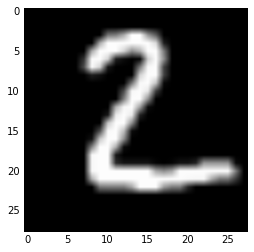

In [27]:
plt.imshow( x_test[1].reshape((28,28)), cmap="gray")

In [28]:
np.argmax(y_hat[0])

2

In [ ]:
np.arange()